In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.linear_model import RidgeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier

## Prototype Model

Generate the prototypes

In [2]:
def gen_prototypes(X_train, y_train):
    ai_proto = np.mean(X_train[y_train == 'ai'], axis=0)
    real_proto = np.mean(X_train[y_train == 'real'], axis=0)
    return ai_proto, real_proto

Categorize each exemplar in the training set by distance to prototype

In [3]:
def prototype_predict(ai_proto, real_proto, stims):
    predictions = []

    for stim in stims:
        dist_ai = -np.linalg.norm(stim - ai_proto)
        dist_real = -np.linalg.norm(stim - real_proto)
        if dist_ai > dist_real:
            predictions.append('ai')
        else:
            predictions.append('real')
    
    return np.array(predictions)

## Exemplar Model

Generate lists of exemplars

In [4]:
def gen_exemplars(X_train, y_train):
    exemplars = {
        'ai': X_train[y_train == 'ai'],
        'real': X_train[y_train == 'real']
    }
    return exemplars

Categorize each exemplar based on highest similarity score to each category

In [5]:
def exemplar_predict(stims, exemplars):
    predictions = []
    for stimulus in stims:
        dist_ai = np.linalg.norm(exemplars['ai'] - stimulus, axis=1)
        ai_similar = np.sum(np.exp(-dist_ai))

        dist_real = np.linalg.norm(exemplars['real'] - stimulus, axis=1)
        real_similar = np.sum(np.exp(-dist_real))
        
        if ai_similar > real_similar:
            predictions.append('ai')
        else:
            predictions.append('real')
            
    return np.array(predictions)

### Results (with ML)

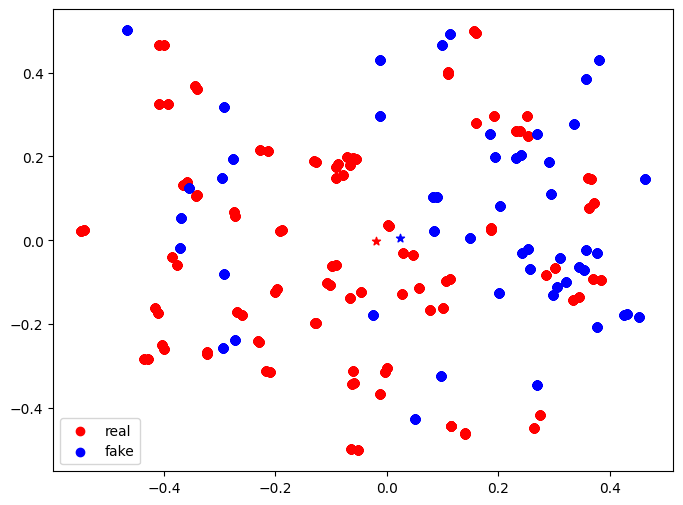

In [6]:
import matplotlib.pyplot as plt

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

df = pd.read_pickle('df_pca_2')  
df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
df["image"] = df["image"].astype(int)

df_merged = pd.merge(df_resp, df, on="image", how="inner")
pca_columns = [i for i in range(0, 2)]

confidence = 0
df_merged = df_merged[df_merged["confidence"] >= confidence]

X = df_merged[pca_columns].values
y = df_merged["choice"].values

fake_proto, real_proto = gen_prototypes(X, y)

fig = plt.figure(figsize=(8, 6))
real = df_merged[df_merged['label'] == 'real']
fake = df_merged[df_merged['label'] == 'fake']

pla = plt.scatter(real[0], real[1], color='red')
plb = plt.scatter(fake[0], fake[1], color='blue')

plt.scatter(real_proto[0], real_proto[1], color='red', marker='*')
plt.scatter(fake_proto[0], fake_proto[1], color='blue', marker='*')

plt.legend([pla, plb], ["real", "fake"])


plt.show()

In [7]:
# [1, 2, 3, 4, 5, 10, 20, 30, 50, 100]
pca_dfs = {
    1:  'df_pca_1',
    2:  'df_pca_2',
    3:  'df_pca_3',
    4:  'df_pca_4',
    5:  'df_pca_5',
    10: 'df_pca_10',
    20: 'df_pca_20',
    30: 'df_pca_30',
    50: 'df_pca_50',
    100:'df_pca_100'
}

results = []

df_resp = pd.read_csv("./DATA AND R CODE/eachresponse.csv")
df_resp = df_resp.dropna(how='any')

for d, df_pca in pca_dfs.items():
    df = pd.read_pickle(df_pca)  
    df["image"] = df["image"].str.extract(r'\((\d+)\)', expand=False)
    df["image"] = df["image"].astype(int)
    
    df_merged = pd.merge(df_resp, df, on="image", how="inner")
    pca_columns = [i for i in range(0, d)]
    
    confidence = 4
    df_merged = df_merged[df_merged["confidence"] >= confidence]
    
    X = df_merged[pca_columns].values
    y = df_merged["choice"].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Prototype
    ai_proto, real_proto = gen_prototypes(X_train, y_train)
    proto_preds = prototype_predict(ai_proto, real_proto, X_test)
    proto_acc = accuracy_score(y_test, proto_preds)

    # Exemplar
    exemplars = gen_exemplars(X_train, y_train)
    exemplar_preds = exemplar_predict(X_test, exemplars)
    exemplar_acc = accuracy_score(y_test, exemplar_preds)

    # ML (RidgeClassifier)
    clf = RidgeClassifier()
    clf.fit(X_train, y_train)
    ml_preds = clf.predict(X_test)
    ml_ridge_acc = accuracy_score(y_test, ml_preds)

    # ML (GradientBoostingClassifier)
    clf_gradientBoost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=3)
    clf_gradientBoost.fit(X_train, y_train)
    ml_gradientBoost_preds = clf_gradientBoost.predict(X_test)
    ml_gradientBoost_acc = accuracy_score(y_test, ml_gradientBoost_preds)

    # ML (AdaBoostClassifier)
    clf_adaBoost = AdaBoostClassifier(n_estimators=100)
    clf_adaBoost.fit(X_train, y_train)
    ml_adaBoost_preds = clf_adaBoost.predict(X_test)
    ml_adaBoost_acc = accuracy_score(y_test, ml_adaBoost_preds)
    
    # ML (KNeighborsClassifier)
    knn = KNeighborsClassifier(n_neighbors = 5)
    knn.fit(X_train, y_train)
    knn_preds = knn.predict(X_test)
    knn_acc = accuracy_score(y_test,knn_preds)

    # ML (BaggingClassifier)
    clf_bagging = BaggingClassifier(estimator = SVC(), n_estimators = 10)
    clf_bagging.fit(X_train, y_train)
    ml_bagging_preds = clf_bagging.predict(X_test)
    ml_bagging_acc = accuracy_score(y_test, ml_bagging_preds)
    
    results.append({
        "dims": d,
        "prototype_acc": proto_acc,
        "exemplar_acc": exemplar_acc,
        "ml_ridge_acc": ml_ridge_acc,
        "ml_gradientBoost_acc": ml_gradientBoost_acc,
        "ml_adaBoost_acc": ml_adaBoost_acc,
        "ml_knn_acc": knn_acc,
        "ml_bagging_acc": ml_bagging_acc,
    })

results_df = pd.DataFrame(results)
print(results_df)

   dims  prototype_acc  exemplar_acc  ml_ridge_acc  ml_gradientBoost_acc  \
0     1       0.564713      0.566645      0.569865              0.658081   
1     2       0.566001      0.566645      0.573084              0.661301   
2     3       0.567933      0.566645      0.573084              0.661301   
3     4       0.569221      0.566645      0.574372              0.662589   
4     5       0.573084      0.566645      0.578236              0.661301   
5    10       0.564070      0.566645      0.587250              0.658725   
6    20       0.640052      0.566645      0.630393              0.662589   
7    30       0.643271      0.566645      0.641983              0.662589   
8    50       0.641983      0.566645      0.645203              0.658081   
9   100       0.641983      0.566645      0.645203              0.660013   

   ml_adaBoost_acc  ml_knn_acc  ml_bagging_acc  
0         0.629105    0.616871        0.597553  
1         0.633612    0.609144        0.594334  
2         0.6258